Dictionary keys being frequencies, values are np arrays of `Nc x Ns x Nt` (channels x samples x trials). 

First import the data from one session

In [16]:
data_file_12 = open("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/OC3.txt", "r")
data_file_12 = data_file_12.read().split(', ')
for i, v in enumerate(data_file_12):
    if '[' in v:
        data_file_12[i] = v.replace('[','')
    if ']\n' in v:
        data_file_12[i] = v.replace(']\n','')

values_12 = [int(i) for i in data_file_12]

from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

fs = 256
filt_ord = 10
pb_rip = 0.2
sb_atten = 80 

fc_lo = 4 # pass band lower freq
fc_hi = 28 # pass band upp freq 
wc_lo = fc_lo/(fs*0.5)
wc_hi = fc_hi/(fs*0.5)

sos_ellip = signal.ellip(filt_ord, pb_rip, sb_atten, (wc_lo, wc_hi), btype='bandpass', output='sos')

filtered = signal.sosfilt(sos_ellip, values_12)

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [
        [
            5.18442631e-04,
            5.91022291e-04,
            5.18442631e-04,
            1.00000000e00,
            -1.58700686e00,
            6.47826110e-01,
        ],
        [
            1.00000000e00,
            -6.71721317e-01,
            1.00000000e00,
            1.00000000e00,
            -1.56164716e00,
            7.42956116e-01,
        ],
        [
            1.00000000e00,
            -1.19862825e00,
            1.00000000e00,
            1.00000000e00,
            -1.53434369e00,
            8.53024717e-01,
        ],
        [
            1.00000000e00,
            -1.36462221e00,
            1.00000000e00,
            1.00000000e00,
            -1.52074686e00,
            9.31086238e-01,
        ],
        [
            1.00000000e00,
            -1.41821305e00,
            1.00000000e00,
            1.00000000e00,
            -1.52570664e00,
            9.80264626e-01,
        ],
    ]
)

filtered_new = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_12)

filtered_board = filtered_new

sourceFile = open('unfilt.txt', 'w')
print(values_12 , file = sourceFile)
sourceFile.close()
# sourceFile = open('filtboard.txt', 'w')
# print((filtered_board - np.mean(filtered_board)).tolist(), file = sourceFile)
# sourceFile.close()
sourceFile = open('filtboard.txt', 'w')
print((filtered_board).tolist(), file = sourceFile)
sourceFile.close()
sourceFile = open('filtscipy.txt', 'w')
print(filtered.tolist() , file = sourceFile)
sourceFile.close()

In [9]:
print(type(filtered))

<class 'numpy.ndarray'>


Text(0.5, 1.0, 'Filtered board')

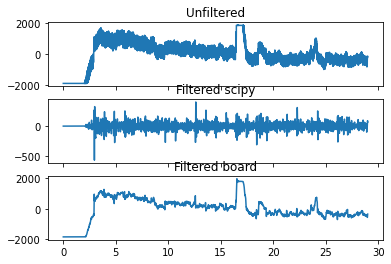

In [4]:
values_12 = [int(i) for i in data_file_12]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
t = np.linspace(0, 29, len(values_12), False)

ax1.plot(t, values_12-np.mean(values_12))
ax1.set_title('Unfiltered')

ax2.plot(t, filtered)
ax2.set_title('Filtered scipy')

ax3.plot(t, filtered_board - np.mean(filtered_board))
ax3.set_title('Filtered board')

Passband the values

Elliptical 10th order bandpass filter with corner frequencies at (4, 28)Hz,
0.2dB passband ripple and 80dB stopband atten

i.e the same filter that will happen on the board

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

fs = 256
filt_ord = 10
pb_rip = 0.2
sb_atten = 80

fc_lo = 4 # pass band lower freq
fc_hi = 28 # pass band upp freq 
wc_lo = fc_lo/(fs*0.5)
wc_hi = fc_hi/(fs*0.5)

sos_ellip = signal.ellip(filt_ord, pb_rip, sb_atten, (wc_lo, wc_hi), btype='bandpass', output='sos')

filtered = signal.sosfilt(sos_ellip, values_10[::2])

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [
        [
            5.18442631e-04,
            5.91022291e-04,
            5.18442631e-04,
            1.00000000e00,
            -1.58700686e00,
            6.47826110e-01,
        ],
        [
            1.00000000e00,
            -6.71721317e-01,
            1.00000000e00,
            1.00000000e00,
            -1.56164716e00,
            7.42956116e-01,
        ],
        [
            1.00000000e00,
            -1.19862825e00,
            1.00000000e00,
            1.00000000e00,
            -1.53434369e00,
            8.53024717e-01,
        ],
        [
            1.00000000e00,
            -1.36462221e00,
            1.00000000e00,
            1.00000000e00,
            -1.52074686e00,
            9.31086238e-01,
        ],
        [
            1.00000000e00,
            -1.41821305e00,
            1.00000000e00,
            1.00000000e00,
            -1.52570664e00,
            9.80264626e-01,
        ],
    ]
)

filtered_new = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_10[::2])

filtered = filtered[256:]
filtered_board = filtered_new[256:]

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
t = np.linspace(0, 29, len(values_10[512::2]), False)

ax1.plot(t, values_10[512::2]-np.mean(values_10[512::2]))
ax1.set_title('Unfiltered')

ax2.plot(t, filtered)
ax2.set_title('Filtered scipy')

ax3.plot(t, filtered_board - np.mean(filtered_board))
ax3.set_title('Filtered board')

# Decoding section

## GCCA, MsetCCA

In [ ]:
from scipy import signal
import numpy as np

freqs =[7,10,12]
downsample_avg_size = 2

filtered_10 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_10)
filtered_10 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_10)]*downsample_avg_size)])[256:]

filtered_12 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_12)
filtered_12 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_12)]*downsample_avg_size)])[256:]

filtered_7 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_7)
filtered_7 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_7)]*downsample_avg_size)])[256:]

print(filtered_7.shape)
print(filtered_10.shape)
print(filtered_12.shape)

In [ ]:
number_of_train = 4
fs = 256

# synth_7 = (synth_X(7,1,256,4).T).reshape(1,fs,4)

train7_reshape = np.array(filtered_7[:fs*number_of_train]).reshape(number_of_train,fs)
train7 = train7_reshape.T.reshape(1,fs,number_of_train)

train10_reshape = np.array(filtered_10[:fs*number_of_train]).reshape(number_of_train,fs)
train10 = train10_reshape.T.reshape(1,fs,number_of_train)

train12_reshape = np.array(filtered_12[:fs*number_of_train]).reshape(number_of_train,fs)
train12 = train12_reshape.T.reshape(1,fs,number_of_train)

train = np.array([train7, train10, train12])

test7 = filtered_7[fs*number_of_train:]
test10 = filtered_10[fs*number_of_train:]
test12 = filtered_12[fs*number_of_train:]

print(train7.shape)
print(len(test7)/fs)

In [ ]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

gcca_7 = []
mset_7 =[]

for begin in range(0, int(len(test7)/256)):
    gcca_decode = gcca.classify(test7[256*begin:256*begin+256].reshape(1,256))
    gcca_7.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test7[256*begin:256*begin+256].reshape(1,256))
    mset_7.append(max(mset_decode, key=mset_decode.get))

print(gcca_7.count(7)/len(gcca_7), '\n', mset_7.count(7)/len(mset_7))

gcca_10 = []
mset_10 =[]

for begin in range(0, int(len(test10)/256)):
    gcca_decode = gcca.classify(test10[256*begin:256*begin+256].reshape(1,256))
    gcca_10.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test10[256*begin:256*begin+256].reshape(1,256))
    mset_10.append(max(mset_decode, key=mset_decode.get))

print(gcca_10.count(10)/len(gcca_10), '\n', mset_10.count(10)/len(mset_10))

gcca_12 = []
mset_12 =[]

for begin in range(0, int(len(test12)/256)):
    gcca_decode = gcca.classify(test12[256*begin:256*begin+256].reshape(1,256))
    gcca_12.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test12[256*begin:256*begin+256].reshape(1,256))
    mset_12.append(max(mset_decode, key=mset_decode.get))

print(gcca_12.count(12)/len(gcca_12), '\n', mset_12.count(12)/len(mset_12))

# Using online dataset

In [ ]:
import pandas as pd
from scipy import signal
import numpy as np
import math
from eeg_lib.utils import standardise

df = pd.read_csv(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\online_dataset\data\subject1.csv",sep=';')
s1_8_57 = standardise(df['F1'].to_numpy())
s1_10 = standardise(df['F2'].to_numpy())
s1_12 = standardise(df['F3'].to_numpy())
s1_15 = standardise(df['F4'].to_numpy())


In [ ]:
freqs =[8.57,10,12,15]
fs = 256
number_of_train = 4

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [
        [
            5.18442631e-04,
            5.91022291e-04,
            5.18442631e-04,
            1.00000000e00,
            -1.58700686e00,
            6.47826110e-01,
        ],
        [
            1.00000000e00,
            -6.71721317e-01,
            1.00000000e00,
            1.00000000e00,
            -1.56164716e00,
            7.42956116e-01,
        ],
        [
            1.00000000e00,
            -1.19862825e00,
            1.00000000e00,
            1.00000000e00,
            -1.53434369e00,
            8.53024717e-01,
        ],
        [
            1.00000000e00,
            -1.36462221e00,
            1.00000000e00,
            1.00000000e00,
            -1.52074686e00,
            9.31086238e-01,
        ],
        [
            1.00000000e00,
            -1.41821305e00,
            1.00000000e00,
            1.00000000e00,
            -1.52570664e00,
            9.80264626e-01,
        ],
    ]
)

filtered_857 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_8_57)
filtered_10 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_10)
filtered_12 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_12)
filtered_15 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_15)


train857_reshape = np.array(filtered_857[:fs*number_of_train]).reshape(number_of_train,fs)
train857 = train857_reshape.T.reshape(1,fs,number_of_train)

train10_reshape = np.array(filtered_10[:fs*number_of_train]).reshape(number_of_train,fs)
train10 = train10_reshape.T.reshape(1,fs,number_of_train)

train12_reshape = np.array(filtered_12[:fs*number_of_train]).reshape(number_of_train,fs)
train12 = train12_reshape.T.reshape(1,fs,number_of_train)

train15_reshape = np.array(filtered_15[:fs*number_of_train]).reshape(number_of_train,fs)
train15 = train15_reshape.T.reshape(1,fs,number_of_train)

train = np.array([train857, train10, train12, train15])

test857 = filtered_857[256*number_of_train:]
test10= filtered_10[256*number_of_train:]
test12 = filtered_12[256*number_of_train:]
test15 = filtered_15[256*number_of_train:]

In [ ]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

gcca_857 = []
mset_857 =[]

for begin in range(0, int(len(test857)/256)):
    gcca_decode = gcca.classify(test857[256*begin:256*begin+256].reshape(1,256))
    gcca_857.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test857[256*begin:256*begin+256].reshape(1,256))
    mset_857.append(max(mset_decode, key=mset_decode.get))

print("GCCA 8.57hz accuracy: ", gcca_857.count(7)/len(gcca_857), '\nMset 8.57hz accuracy: ', mset_857.count(7)/len(mset_857))

gcca_10 = []
mset_10 =[]

for begin in range(0, int(len(test10)/256)):
    gcca_decode = gcca.classify(test10[256*begin:256*begin+256].reshape(1,256))
    gcca_10.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test10[256*begin:256*begin+256].reshape(1,256))
    mset_10.append(max(mset_decode, key=mset_decode.get))

print("GCCA 10hz accuracy: ",gcca_10.count(10)/len(gcca_10), '\nMset 10hz accuracy: ', mset_10.count(10)/len(mset_10))

gcca_12 = []
mset_12 =[]

for begin in range(0, int(len(test12)/256)):
    gcca_decode = gcca.classify(test12[256*begin:256*begin+256].reshape(1,256))
    gcca_12.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test12[256*begin:256*begin+256].reshape(1,256))
    mset_12.append(max(mset_decode, key=mset_decode.get))

print("GCCA 12hz accuracy: ",gcca_12.count(12)/len(gcca_12), '\nMset 12hz accuracy: ', mset_12.count(12)/len(mset_12))

gcca_15 = []
mset_15 =[]

for begin in range(0, int(len(test15)/256)):
    gcca_decode = gcca.classify(test15[256*begin:256*begin+256].reshape(1,256))
    gcca_15.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test15[256*begin:256*begin+256].reshape(1,256))
    mset_15.append(max(mset_decode, key=mset_decode.get))

print("GCCA 15hz accuracy: ",gcca_15.count(15)/len(gcca_15), '\nMset 15hz accuracy: ', mset_15.count(15)/len(mset_15))

# 64hz over 4 second approach - own data

In [ ]:
import numpy as np
from scipy import signal

data_file_7 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\7hz\7hz_LED2.txt", "r")
data_file_7 = data_file_7.read().split(', ')
for i, v in enumerate(data_file_7):
    if '[' in v:
        data_file_7[i] = v.replace('[','')
    if ']\n' in v:
        data_file_7[i] = v.replace(']\n','')

downsample_avg_size = 1

values_7 = [int(i) for i in data_file_7]
values_7 = [sum(group) / downsample_avg_size for group in zip(*[iter(values_7)]*downsample_avg_size)]

data_file_10 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\10hz\10hz_LED2.txt", "r")
data_file_10 = data_file_10.read().split(', ')
for i, v in enumerate(data_file_10):
    if '[' in v:
        data_file_10[i] = v.replace('[','')
    if ']\n' in v:
        data_file_10[i] = v.replace(']\n','')

values_10 = [int(i) for i in data_file_10]
values_10 = [sum(group) / downsample_avg_size for group in zip(*[iter(values_10)]*downsample_avg_size)]

data_file_12 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\12hz\12hz_LED2.txt", "r")
data_file_12 = data_file_12.read().split(', ')
for i, v in enumerate(data_file_12):
    if '[' in v:
        data_file_12[i] = v.replace('[','')
    if ']\n' in v:
        data_file_12[i] = v.replace(']\n','')

values_12 = [int(i) for i in data_file_12] #because sampled at 512, sos filter uses 256
values_12 = [sum(group) / downsample_avg_size for group in zip(*[iter(values_12)]*downsample_avg_size)]

In [ ]:
freqs =[7,10,12]
fs = 256

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [
        [
            5.18442631e-04,
            5.91022291e-04,
            5.18442631e-04,
            1.00000000e00,
            -1.58700686e00,
            6.47826110e-01,
        ],
        [
            1.00000000e00,
            -6.71721317e-01,
            1.00000000e00,
            1.00000000e00,
            -1.56164716e00,
            7.42956116e-01,
        ],
        [
            1.00000000e00,
            -1.19862825e00,
            1.00000000e00,
            1.00000000e00,
            -1.53434369e00,
            8.53024717e-01,
        ],
        [
            1.00000000e00,
            -1.36462221e00,
            1.00000000e00,
            1.00000000e00,
            -1.52074686e00,
            9.31086238e-01,
        ],
        [
            1.00000000e00,
            -1.41821305e00,
            1.00000000e00,
            1.00000000e00,
            -1.52570664e00,
            9.80264626e-01,
        ],
    ]
)

downsample_avg_size = 1

# filtered_10 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_10)
filtered_10 = values_10
filtered_10 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_10)]*downsample_avg_size)])

# filtered_12 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_12)
filtered_12 = values_12
filtered_12 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_12)]*downsample_avg_size)])

# filtered_7 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_7)
filtered_7 = values_7
filtered_7 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_7)]*downsample_avg_size)])

print(filtered_7.shape)
print(filtered_10.shape)
print(filtered_12.shape)

In [ ]:
number_of_train = 8

train7_reshape = np.array(filtered_7[:fs*number_of_train]).reshape(number_of_train,fs)
train7 = train7_reshape.T.reshape(1,fs,number_of_train)

train10_reshape = np.array(filtered_10[:fs*number_of_train]).reshape(number_of_train,fs)
train10 = train10_reshape.T.reshape(1,fs,number_of_train)

train12_reshape = np.array(filtered_12[:fs*number_of_train]).reshape(number_of_train,fs)
train12 = train12_reshape.T.reshape(1,fs,number_of_train)

train = np.array([train7, train10, train12])
test7 = filtered_7[fs*number_of_train:]
test10= filtered_10[fs*number_of_train:]
test12 = filtered_12[fs*number_of_train:]

print(train7.shape,len(test7)/256)

In [ ]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs=512, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

gcca_7 = []
mset_7 =[]

for begin in range(0, int(len(test7)/fs)):
    gcca_decode = gcca.classify(test7[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_7.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test7[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_7.append(max(mset_decode, key=mset_decode.get))

print("GCCA 7hz accuracy: ",gcca_7.count(7)/len(gcca_7), '\nMset 7hz accuracy: ', mset_7.count(7)/len(mset_7))

gcca_10 = []
mset_10 = []

for begin in range(0, int(len(test10)/fs)):
    gcca_decode = gcca.classify(test10[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_10.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test10[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_10.append(max(mset_decode, key=mset_decode.get))

print("GCCA 10hz accuracy: ",gcca_10.count(10)/len(gcca_10), '\nMset 10hz accuracy: ', mset_10.count(10)/len(mset_10))

gcca_12 = []
mset_12 =[]

for begin in range(0, int(len(test12)/fs)):
    gcca_decode = gcca.classify(test12[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_12.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test12[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_12.append(max(mset_decode, key=mset_decode.get))

print("GCCA 12hz accuracy: ",gcca_12.count(12)/len(gcca_12), '\nMset 12hz accuracy: ', mset_12.count(12)/len(mset_12))

# Testing with synthetic signal

In [41]:
import random
import numpy as np

def synth_x(f, Ns, noise_power=0.5, fs=256):
    """
    generate a synthetic signal vector
    
    args:
    Ns [int]: number of samples (time samples)
    noise_power [float]: variance of WGN noise distribution
    """
    t = np.arange(0, Ns/fs, 1/fs)
    return np.sin(t*2*np.pi*f)*(1+random.random()*noise_power)

def synth_X(f, Nc, Ns, Nt=1, noise_power=0.5, fs=256, f_std=0.02):
    """
    Generate a matrix of several variations of the same target signal. This is used
    to simulate the measurement of a common signal over multiple EEG channels 
    that have different SNR characteristics.
    
    args:
    f [float]: target frequency of synthetic signal (Hz)
    Nc [int]: number of channels
    Ns [int]: number of samples (time samples)
    Ns [int]: number of iid trials
    noise_power [float]: variance of WGN noise distribution
    fs [float]: sampling frequency (Hz)
    f_std [float]: standard dev. of freq. in generated signal across channels to simulate interference from other frequency components over different channels
    """
    def _synth():
        X = []
        for i in range(Nc): # simulate noisy sinusoids with varying SNR across Nc channels
            f_i = f*(1+random.random()*f_std)
            x = synth_x(f_i, Ns, noise_power=noise_power, fs=fs)

            X.append(x)

        return np.array(X)
    
    if Nt <= 1:
        return _synth()
    else:
        trials = []
        for i in range(Nt):
            trials.append(_synth().flatten())

        return np.array(trials)

In [60]:
freqs = [7, 10, 12]
fs=256

print(synth_X(7,1,256,4).shape)
synth_7 = (synth_X(7,1,256,4).T).reshape(1,fs,4)
print(synth_7.shape)
synth_10 = (synth_X(10,1,256,4).T).reshape(1,fs,4)
synth_12 = (synth_X(12,1,256,4).T).reshape(1,fs,4)

train = np.array([synth_7, synth_10, synth_12])

(4, 256)


ValueError: cannot reshape array of size 1 into shape (1,256,4)

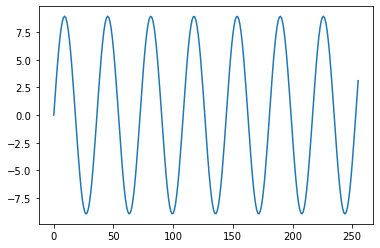

In [68]:
x = synth_X(7,1,256,4,10)
plt.plot(x[1])

7
7
{7: 0.2677221246477834, 10: 0.0037745267830635565, 12: 0.002310725772868298}
7
{7: 0.44605320759636835, 10: 0.1946488730272759, 12: 0.1429916324066153}
10
10
{7: 0.0003570615040257715, 10: 1.6546125423297222, 12: 0.001195056308574616}
10
{7: 0.20180327525609387, 10: 0.9897911784347806, 12: 0.18083207002305512}
12
12
{7: 0.0009291431242681781, 10: 0.004541758502572933, 12: 1.113880285777193}
12
{7: 0.0930330879994915, 10: 0.25898649466081386, 12: 0.8221294434829342}


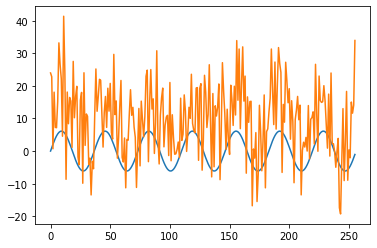

In [62]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

import matplotlib.pyplot as plt

synth_7_test = synth_x(7,256,noise_power=100)
plt.plot(synth_7_test)
synth_7_1_test = (synth_7_test + np.random.normal(10, 10, synth_7_test.shape))
synth_7_test = synth_7_1_test.reshape(1,fs)
plt.plot(synth_7_1_test)

synth_10_test = synth_x(10,256,noise_power=100).reshape(1,fs)
synth_10_1_test = (synth_10_test + np.random.normal(10, 10, synth_10_test.shape))
synth_10_test = synth_10_1_test.reshape(1,fs)

synth_12_test = synth_x(12,256,noise_power=100).reshape(1,fs)
synth_12_1_test = (synth_12_test + np.random.normal(10, 10, synth_12_test.shape))
synth_12_test = synth_12_1_test.reshape(1,fs)

print("7")
gcca_res = gcca.classify(synth_7_test)
for key, prob in gcca_res.items():
    gcca_res[key] = abs(prob)
mset_res = mset_cca.classify(synth_7_test)
print(max(gcca_res, key=gcca_res.get))
print(gcca_res)
print(max(mset_res, key=gcca_res.get))
print(mset_res)

print("10")
gcca_res = gcca.classify(synth_10_test)
for key, prob in gcca_res.items():
    gcca_res[key] = abs(prob)
mset_res = mset_cca.classify(synth_10_test)
print(max(gcca_res, key=gcca_res.get))
print(gcca_res)
print(max(mset_res, key=gcca_res.get))
print(mset_res)

print("12")
gcca_res = gcca.classify(synth_12_test)
for key, prob in gcca_res.items():
    gcca_res[key] = abs(prob)
mset_res = mset_cca.classify(synth_12_test)
print(max(gcca_res, key=gcca_res.get))
print(gcca_res)
print(max(mset_res, key=gcca_res.get))
print(mset_res)

In [12]:
from eeg_lib.cca import CCA

print(synth_x(7,256).shape)
cca = CCA(freqs, fs, Nh=1)
cca.classify(synth_x(7,256))

(256,)


ValueError: operands could not be broadcast together with shapes (2,256) (2,) 

# Refactored into functions

In [20]:
import numpy as np
from scipy import signal
from sklearn.model_selection import LeavePOut
import random
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP
from eeg_lib.utils import standardise
import matplotlib.pyplot as plt
import pandas as pd

def synth_x(f, Ns, noise_power=0.5, fs=256):
    t = np.arange(0, Ns/fs, 1/fs)
    return np.sin(t*2*np.pi*f)*(1+random.random()*noise_power)

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [   [5.18442631e-04, 5.91022291e-04, 5.18442631e-04, 1.00000000e00, -1.58700686e00, 6.47826110e-01,],
        [1.00000000e00, -6.71721317e-01, 1.00000000e00, 1.00000000e00, -1.56164716e00, 7.42956116e-01,],
        [1.00000000e00, -1.19862825e00, 1.00000000e00, 1.00000000e00, -1.53434369e00, 8.53024717e-01,],
        [1.00000000e00, -1.36462221e00, 1.00000000e00, 1.00000000e00, -1.52074686e00, 9.31086238e-01,],
        [1.00000000e00, -1.41821305e00, 1.00000000e00, 1.00000000e00, -1.52570664e00, 9.80264626e-01,],
    ])

fs_openbci = 200
filt_ord = 10
pb_rip = 0.2
sb_atten = 80

fc_lo = 4 # pass band lower freq
fc_hi = 28 # pass band upp freq 
wc_lo = fc_lo/(fs_openbci*0.5)
wc_hi = fc_hi/(fs_openbci*0.5)

sos_openbci = signal.ellip(filt_ord, pb_rip, sb_atten, (wc_lo, wc_hi), btype='bandpass', output='sos')

fs = 250
filt_ord = 10
pb_rip = 0.2
sb_atten = 80 

fc_lo = 4 # pass band lower freq
fc_hi = 28 # pass band upp freq 
wc_lo = fc_lo/(fs*0.5)
wc_hi = fc_hi/(fs*0.5)

sos_ellip = signal.ellip(filt_ord, pb_rip, sb_atten, (wc_lo, wc_hi), btype='bandpass', output='sos')

def load_array_data(file_path):
    data_file = open(file_path, "r")
    data_file = data_file.read().split(', ')
    for i, v in enumerate(data_file):
        if '[' in v:
            data_file[i] = v.replace('[','')
        if ']\n' in v:
            data_file[i] = v.replace(']\n','')
            
    values = [int(i) for i in data_file]
    return values

def load_array_data_float(file_path):
    data_file = open(file_path, "r")
    data_file = data_file.read().split(', ')
    for i, v in enumerate(data_file):
        if '[' in v:
            data_file[i] = v.replace('[','')
        if ']\n' in v:
            data_file[i] = v.replace(']\n','')
            
    values = [float(i) for i in data_file]
    return values

def load_array_data_online(file_path):
    data_file = open(file_path, "r")
    data_file = data_file.read().split(',')            
    values = [float(i) for i in data_file]
    return values

def average_every_n(values, size):
#     return np.array([sum(group) / size for group in zip(*[iter(values)]*size)])
    return values[::size]

def sos_filter_OpenBCI(values):
    return signal.sosfilt(sos_openbci, values)

def sos_filter_256(values):
    return signal.sosfilt(sos_ellip, values)
#     return signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values)

def process_data(data, no_samples, no_train, remove_DC=True, apply_filter=False, ds_rate=1, downsample=False):

    data = data[:int(len(data)/no_samples)*no_samples]
    
    if remove_DC:
        data = data - sum(data)/len(data)
        if apply_filter:
            data = sos_filter_256(data)[no_samples:]
            plt.plot(data[:256])
            
    if downsample:
        print("downsampling",len(data))
        data = average_every_n(data, ds_rate)
        print("to",len(data))
        data = data[:int(len(data)/no_samples)*no_samples]
        
    data_reshape = data.reshape(int(len(data)/no_samples),no_samples)
    data = data_reshape.T.reshape(1,no_samples,int(len(data)/no_samples))
    return np.array(data)

def process_data_OpenBCI(data, no_samples, no_train, remove_DC=True, apply_filter=False, ds_rate=1, downsample=False):

    data = data[:int(len(data)/no_samples)*no_samples]
    
    if remove_DC:
        data = data - sum(data)/len(data)
        if apply_filter:
            data = sos_filter_OpenBCI(data)[no_samples:]
            plt.plot(data[:256])
            
    if downsample:
        print("downsampling",len(data))
        data = average_every_n(data, ds_rate)
        print("to",len(data))
        data = data[:int(len(data)/no_samples)*no_samples]
        
    data_reshape = data.reshape(int(len(data)/no_samples),no_samples)
    data = data_reshape.T.reshape(1,no_samples,int(len(data)/no_samples))
    return np.array(data)

def prepare_data(data, frequency, fs, fs_synth, no_samples, no_train, remove_DC=True, apply_filter=True, downsample=False, ds_avg=1, synth_power=0, noise_power=0):
    data = data + synth_power*synth_x(frequency, len(data), noise_power=0, fs=fs_synth)
    values = process_data(data,no_samples,no_train,remove_DC=remove_DC,apply_filter=apply_filter,ds_rate=ds_avg,downsample=downsample)
    return values

def prepare_data_OpenBCI(data, frequency, fs, fs_synth, no_samples, no_train, remove_DC=True, apply_filter=True, downsample=False, ds_avg=1, synth_power=0, noise_power=0):
    data = data + synth_power*synth_x(frequency, len(data), noise_power=0, fs=fs_synth)
    values = process_data_OpenBCI(data,no_samples,no_train,remove_DC=remove_DC,apply_filter=apply_filter,ds_rate=ds_avg,downsample=downsample)
    return values

def generate_train_test_idxs(data,no_train):
    lpo = LeavePOut(p=no_train)
    no_trials = data.shape[-1]
    return list(lpo.split(range(no_trials)))

def flatten(t):
    return [item for sublist in t for item in sublist]

def test_gcca_mset(data, data_idxs, freqs, fs, no_samples, number_runs=10):
    # Nf x Nc x Ns x Nt
    gcca = GCCA_SSVEP(freqs, fs, Nh=1)
    mset_cca = MsetCCA_SSVEP(freqs)
    gcca_total_acc = []
    mset_total_acc = []
    gcca_freq_acc = dict((key,[]) for key in freqs)
    mset_freq_acc = dict((key,[]) for key in freqs)

    for i in range(number_runs):
        # Nf x Nc x Ns x Nt
        train = data[:,:,:,data_idxs[i][1]]
        test = data[:,:,:,data_idxs[i][0]]

        gcca.fit(train)
        mset_cca.fit(train)
        
        for freq, value in enumerate(freqs):
            gcca_res = []
            mset_res = []
            #print("############################# Frequency:", value, " #############################")
            for test_idx in range(test.shape[-1]):
                test_now = test[freq, :, :, test_idx]
                
                gcca_decode = gcca.classify(test_now)
#                 print(gcca_decode)
                for key, prob in gcca_decode.items():
                    gcca_decode[key] = abs(prob)
                
                gcca_res.append(max(gcca_decode, key=gcca_decode.get))
                
                mset_decode = mset_cca.classify(test_now)
#                 print(mset_decode)
                mset_res.append(max(mset_decode, key=mset_decode.get))
            #print("GCCA accuracy {gcca_acc}\nMsetCCA {mset_acc}".format(gcca_acc=gcca_res.count(value)/len(gcca_res),mset_acc=mset_res.count(value)/len(mset_res)))
            
            gcca_total_acc.append(gcca_res.count(value)/len(gcca_res))
            mset_total_acc.append(mset_res.count(value)/len(mset_res))
            gcca_freq_acc[value].append(gcca_res)
            mset_freq_acc[value].append(mset_res)
    
    total_gcca = sum(gcca_total_acc)/len(gcca_total_acc)
    print("GCCA Total Average Accuracy:", sum(gcca_total_acc)/len(gcca_total_acc))
    total_mset = sum(mset_total_acc)/len(mset_total_acc)
    print("MsetCCA Total Average Accuracy:", sum(mset_total_acc)/len(mset_total_acc))
    
    gcca_freq_scores = []
    mset_freq_scores = []
    
    for key, value in gcca_freq_acc.items():
        flattened = flatten(value)
        print(value)
        print("GCCA {frequency}hz accuracy:{result}".format(frequency=key, result=flattened.count(key)/len(flattened)))
        gcca_freq_scores.append(flattened.count(key)/len(flattened))
    for key, value in mset_freq_acc.items():
        print(value)
        flattened = flatten(value)
        print("MsetCCA {frequency}hz accuracy:{result}".format(frequency=key, result=flattened.count(key)/len(flattened)))
        mset_freq_scores.append(flattened.count(key)/len(flattened))
        
    return total_gcca, total_mset, gcca_freq_scores, mset_freq_scores

# Testing

In [31]:
ds = 1 #downsample averaging size
if ds > 1:
    downsample=True
else:
    downsample=False
freqs = [7,10,12]
fs_synth = 256
fs = int(fs_synth/ds)
over_n_seconds = 1
number_of_samples = fs*over_n_seconds
number_of_train = 2
removeDC = True
applyFilter = False
synth_power = 0
synth_noise = 0

data_file_7 = load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\Proper_Gain_255\7hz_3.txt")
test = np.array(data_file_7) - sum(np.array(data_file_7))/len(np.array(data_file_7))
print(min(data_file_7),max(data_file_7))
values_7 = prepare_data(data_file_7, 7, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

data_file_10 = load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\Proper_Gain_255\10hz_3.txt")
values_10 = prepare_data(data_file_10, 10, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample,ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

data_file_12 = load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\Proper_Gain_255\12hz_3.txt")

print(min(data_file_12),max(data_file_12))
values_12 = prepare_data(data_file_12, 12, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample,ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

print(values_12.shape, values_10.shape, values_7.shape)

data_packed = np.array([values_7, values_10, values_12])

print(data_packed.shape)

train_test_idxs = generate_train_test_idxs(data_packed, number_of_train)
print(len(train_test_idxs))
print((train_test_idxs[0]))
test_gcca_mset(data_packed, train_test_idxs, freqs, fs, number_of_samples, number_runs=1)

540 2461
178 3031
(1, 256, 30) (1, 256, 30) (1, 256, 30)
(3, 1, 256, 30)
435
(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), array([0, 1]))
GCCA Total Average Accuracy: 0.5952380952380952
MsetCCA Total Average Accuracy: 0.6666666666666666
[[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 12, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 12, 7]]
GCCA 7hz accuracy:0.9285714285714286
[[10, 12, 12, 10, 12, 12, 10, 12, 10, 12, 12, 12, 12, 10, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10]]
GCCA 10hz accuracy:0.25
[[7, 12, 12, 7, 12, 12, 10, 7, 12, 12, 12, 12, 12, 12, 12, 10, 12, 7, 10, 10, 12, 12, 10, 7, 10, 12, 12, 12]]
GCCA 12hz accuracy:0.6071428571428571
[[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]]
MsetCCA 7hz accuracy:1.0
[[10, 12, 12, 10, 12, 10, 10, 12, 10, 10, 12, 10, 12, 12, 12, 12, 10, 12, 10, 12, 12, 12, 12, 12, 12, 10, 12, 12]]
MsetCCA 10hz accuracy:0.3571428571428571

(0.5952380952380952,
 0.6666666666666666,
 [0.9285714285714286, 0.25, 0.6071428571428571],
 [1.0, 0.35714285714285715, 0.6428571428571429])

# Own data

In [9]:
ds = 1 #downsample averaging size
if ds > 1:
    downsample=True
else:
    downsample=False
freqs = [7,10,12]
fs_synth = 256
fs = int(fs_synth/ds)
over_n_seconds = 1
number_of_samples = fs*over_n_seconds
number_of_train = 4
removeDC = True
applyFilter = False
synth_power = 0
synth_noise = 0

data_file_7 = load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\decreased_noise_location\7_3.txt")
new_data_file_7 = []
for i in range(0,len(data_file_7),fs_synth):
    if not i+256 > len(data_file_7):
        new_data_file_7.append(standardise(np.array(data_file_7[i:i+256])).tolist())
data_file_7 = flatten(new_data_file_7)

values_7 = prepare_data(data_file_7, 7, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

data_file_10 = load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\decreased_noise_location\10_3.txt")
new_data_file_10 = []
for i in range(0,len(data_file_10),fs_synth):
    if not i+256 > len(data_file_10):
        new_data_file_10.append(standardise(np.array(data_file_10[i:i+256])).tolist())
values_10 = prepare_data(data_file_10, 10, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample,ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

data_file_12 = load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\decreased_noise_location\12_3.txt")
new_data_file_12 = []
for i in range(0,len(data_file_12),fs_synth):
    if not i+256 > len(data_file_12):
        new_data_file_12.append(standardise(np.array(data_file_12[i:i+256])).tolist())
data_file_12 = flatten(new_data_file_12)

values_12 = prepare_data(data_file_12, 12, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample,ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

print(values_12.shape, values_10.shape, values_7.shape)

data_packed = np.array([values_7, values_10, values_12])

print(data_packed.shape)

train_test_idxs = generate_train_test_idxs(data_packed, number_of_train)
print(len(train_test_idxs))
print((train_test_idxs[0]))
test_gcca_mset(data_packed, train_test_idxs, freqs, fs, number_of_samples, number_runs=1)

(1, 256, 30) (1, 256, 30) (1, 256, 30)
(3, 1, 256, 30)
27405
(array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29]), array([0, 1, 2, 3]))
GCCA Total Average Accuracy: 0.35897435897435903
MsetCCA Total Average Accuracy: 0.3333333333333333
GCCA 7hz accuracy:0.2692307692307692
GCCA 10hz accuracy:0.19230769230769232
GCCA 12hz accuracy:0.6153846153846154
MsetCCA 7hz accuracy:0.11538461538461539
MsetCCA 10hz accuracy:0.19230769230769232
MsetCCA 12hz accuracy:0.6923076923076923


(0.35897435897435903,
 0.3333333333333333,
 [0.2692307692307692, 0.19230769230769232, 0.6153846153846154],
 [0.11538461538461539, 0.19230769230769232, 0.6923076923076923])

# FOR THE PROCESSING OF DATA

2560 2560 2560
1024 1024 1024
(1, 256, 13) (1, 256, 13) (1, 256, 13)
(3, 1, 256, 13)
715
(array([ 4,  5,  6,  7,  8,  9, 10, 11, 12]), array([0, 1, 2, 3]))
GCCA Total Average Accuracy: 0.1851851851851852
MsetCCA Total Average Accuracy: 0.5185185185185185
GCCA 7hz accuracy:0.3333333333333333
GCCA 10hz accuracy:0.1111111111111111
GCCA 12hz accuracy:0.1111111111111111
MsetCCA 7hz accuracy:0.6666666666666666
MsetCCA 10hz accuracy:0.2222222222222222
MsetCCA 12hz accuracy:0.6666666666666666


(0.1851851851851852,
 0.5185185185185185,
 [0.3333333333333333, 0.1111111111111111, 0.1111111111111111],
 [0.6666666666666666, 0.2222222222222222, 0.6666666666666666])

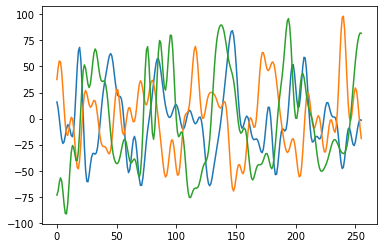

In [54]:
ds = 1 #downsample averaging size
if ds > 1:
    downsample=True
else:
    downsample=False
freqs = [7,10,12]
fs_synth = 256
fs = int(fs_synth/ds)
over_n_seconds = 1
number_of_samples = fs*over_n_seconds
number_of_train = 4
removeDC = True
applyFilter = True
synth_power = 0
synth_noise = 0

data_file_all = load_array_data_float("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/livedata/on_board_downsample_filter1/decoding_data.txt")
# data_file_all = load_array_data_float(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\livedata\on_board_downsample_filter\decoding_data.txt")
test_7 = data_file_all[:256*10]
test_10 = data_file_all[256*10:256*20]
test_12 = data_file_all[256*20:256*30]

print(len(test_7),len(test_10),len(test_12))

train_7 = load_array_data_float("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/livedata/on_board_downsample_filter1/7hz_calibration.txt")
# train_7 = load_array_data_float(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\livedata\on_board_downsample_filter\7hz_calibration.txt")
train_10 = load_array_data_float("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/livedata/on_board_downsample_filter1/10hz_calibration.txt")
# train_10 = load_array_data_float(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\livedata\on_board_downsample_filter\10hz_calibration.txt")
train_12 = load_array_data_float("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/livedata/on_board_downsample_filter1/12hz_calibration.txt")
# train_12 = load_array_data_float(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\livedata\on_board_downsample_filter\12hz_calibration.txt")

print(len(train_7),len(train_10),len(train_12))

data_file_7 = flatten([train_7[:fs_synth*number_of_train], test_7])
data_file_10 = flatten([train_10[:fs_synth*number_of_train], test_10])
data_file_12 = flatten([train_12[:fs_synth*number_of_train], test_12])

values_7 = prepare_data(data_file_7, 7, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)
values_10 = prepare_data(data_file_10, 10, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)
values_12 = prepare_data(data_file_12, 12, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

print(values_12.shape, values_10.shape, values_7.shape)

data_packed = np.array([values_7, values_10, values_12])

print(data_packed.shape)

train_test_idxs = generate_train_test_idxs(data_packed, number_of_train)
print(len(train_test_idxs))
print((train_test_idxs[0]))
test_gcca_mset(data_packed, train_test_idxs, freqs, fs, number_of_samples, number_runs=1)

### Online Dataset

[1, 2, 3, 4, 5, 6]
(1, 250, 29) (1, 250, 29) (1, 250, 29)
(3, 1, 250, 29)
475020
(array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28]), array([0, 1, 2, 3, 4, 5]))
GCCA Total Average Accuracy: 0.4492753623188406
MsetCCA Total Average Accuracy: 0.5652173913043478
GCCA 8hz accuracy:0.5652173913043478
GCCA 10hz accuracy:0.34782608695652173
GCCA 12hz accuracy:0.43478260869565216
MsetCCA 8hz accuracy:0.5652173913043478
MsetCCA 10hz accuracy:0.6521739130434783
MsetCCA 12hz accuracy:0.4782608695652174
(1, 250, 29) (1, 250, 29) (1, 250, 29)
(3, 1, 250, 29)
475020
(array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28]), array([0, 1, 2, 3, 4, 5]))
GCCA Total Average Accuracy: 0.5652173913043478
MsetCCA Total Average Accuracy: 0.6666666666666666
GCCA 8hz accuracy:0.6956521739130435
GCCA 10hz accuracy:0.6086956521739131
GCCA 12hz accuracy:0.391304347826087
MsetCCA 8hz accuracy:0.739130434782608

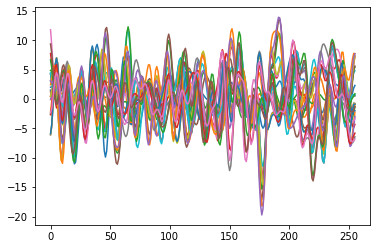

In [36]:
# import random

ds = 1 #downsample averaging size
if ds > 1:
    downsample=True
else:
    downsample=False
freqs = [8,10,12]
fs_synth = 250
fs = int(fs_synth/ds)
over_n_seconds = 1
number_of_samples = fs*over_n_seconds
number_of_train = 6
removeDC = True
applyFilter = True
synth_power = 0
synth_noise = 0

gcca_arr = {}
mset_arr = {}
gcca_f = {'Pz':[], 'PO5':[], 'PO3':[], 'POz':[], 'PO4':[], 'PO6':[], 'O1':[], 'Oz':[], 'O2':[]}
mset_f = {'Pz':[], 'PO5':[], 'PO3':[], 'POz':[], 'PO4':[], 'PO6':[], 'O1':[], 'Oz':[], 'O2':[]}

blocks = [i for i in range(1,7)]
channel_locations = ['Pz', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'O1', 'Oz', 'O2']
print(blocks)
for channel in range(1,10):
    data_file_7 = []
    for block in blocks:
        data_file_7 += load_array_data_online("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/mnakanishi/8hz/8hz_channel_0{c}_0{b}".format(c=channel,b=block))                                       
#         data_file_7 += load_array_data_online(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\mnakanishi\8hz\8hz_channel_0{c}_0{b}".format(c=channel,b=block))                                       

    values_7 = prepare_data(data_file_7, 8, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

    data_file_10 = []
    for block in blocks:
        data_file_10 += load_array_data_online("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/mnakanishi/10hz/10hz_channel_0{c}_0{b}".format(c=channel,b=block))
#         data_file_10 += load_array_data_online(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\mnakanishi\10hz\10hz_channel_0{c}_0{b}".format(c=channel,b=block))                                       

    values_10 = prepare_data(data_file_10, 10, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample,ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

    data_file_12 = []
    for block in blocks:
        data_file_12 += load_array_data_online("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/mnakanishi/12hz/12hz_channel_0{c}_0{b}".format(c=channel,b=block))
#         data_file_12 += load_array_data_online(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\mnakanishi\12hz\12hz_channel_0{c}_0{b}".format(c=channel,b=block))                                       
    values_12 = prepare_data(data_file_12, 12, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample,ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

    print(values_12.shape, values_10.shape, values_7.shape)

    data_packed = np.array([values_7, values_10, values_12])

    print(data_packed.shape)

    train_test_idxs = generate_train_test_idxs(data_packed, number_of_train)
    print(len(train_test_idxs))
    print((train_test_idxs[0]))
    gcca, mset, gccaf, msetf = test_gcca_mset(data_packed, train_test_idxs, freqs, fs, number_of_samples, number_runs=1)
    gcca_arr[channel_locations[channel-1]] = gcca
    mset_arr[channel_locations[channel-1]] = mset
    gcca_f[channel_locations[channel-1]].append(gccaf)
    mset_f[channel_locations[channel-1]].append(msetf)

In [37]:
import json

print("GCCA:", json.dumps(gcca_arr, indent=4, sort_keys=True))
print("MsetCCA:", json.dumps(mset_arr, indent=4, sort_keys=True))

print("GCCA Frequencies:", gcca_f)
print("MsetCCA Frequencies:", mset_f)

GCCA: {
    "O1": 0.5507246376811594,
    "O2": 0.463768115942029,
    "Oz": 0.7101449275362319,
    "PO3": 0.536231884057971,
    "PO4": 0.5942028985507246,
    "PO5": 0.5652173913043478,
    "PO6": 0.391304347826087,
    "POz": 0.6521739130434783,
    "Pz": 0.4492753623188406
}
MsetCCA: {
    "O1": 0.7246376811594203,
    "O2": 0.47826086956521735,
    "Oz": 0.7246376811594203,
    "PO3": 0.7101449275362319,
    "PO4": 0.6376811594202899,
    "PO5": 0.6666666666666666,
    "PO6": 0.4202898550724638,
    "POz": 0.8115942028985508,
    "Pz": 0.5652173913043478
}
GCCA Frequencies: {'Pz': [[0.5652173913043478, 0.34782608695652173, 0.43478260869565216]], 'PO5': [[0.6956521739130435, 0.6086956521739131, 0.391304347826087]], 'PO3': [[0.6956521739130435, 0.5652173913043478, 0.34782608695652173]], 'POz': [[0.9130434782608695, 0.782608695652174, 0.2608695652173913]], 'PO4': [[0.8695652173913043, 0.7391304347826086, 0.17391304347826086]], 'PO6': [[0.391304347826087, 0.391304347826087, 0.3913043

### OpenBCI

downsampling 25200
to 6300
downsampling 25200
to 6300
downsampling 25400
to 6350
[31, 31, 31]
(1, 200, 31) (1, 200, 31) (1, 200, 31)
Data shape: (3, 1, 200, 31)
[[[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], [0, 1, 2, 3]]]
GCCA Total Average Accuracy: 0.382716049382716
MsetCCA Total Average Accuracy: 0.30864197530864196
GCCA 7hz accuracy:0.25925925925925924
GCCA 10hz accuracy:0.5185185185185185
GCCA 12hz accuracy:0.37037037037037035
MsetCCA 7hz accuracy:0.2962962962962963
MsetCCA 10hz accuracy:0.2962962962962963
MsetCCA 12hz accuracy:0.3333333333333333
downsampling 25200
to 6300
downsampling 25200
to 6300
downsampling 25400
to 6350
[31, 31, 31]
(1, 200, 31) (1, 200, 31) (1, 200, 31)
Data shape: (3, 1, 200, 31)
[[[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], [0, 1, 2, 3]]]
GCCA Total Average Accuracy: 0.345679012345679
MsetCCA Total Average Accuracy: 0.2839506172839506
GC

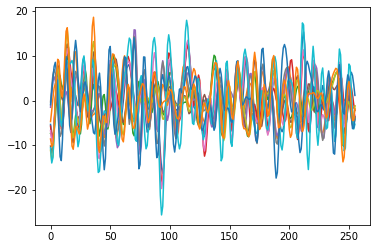

In [16]:
import pandas as pd
import random
import json

ds = 4 #downsample averaging size
if ds > 1:
    downsample=True
else:
    downsample=False
freqs = [7,10,12]
fs_synth = 200
fs = int(fs_synth/ds)
over_n_seconds = 4
number_of_samples = fs*over_n_seconds
removeDC = True
applyFilter = True
synth_power = 0
synth_noise = 0

blocks=6
freqs = [7, 10, 12]
data = {}

gcca_arr = {}
mset_arr = {}
gcca_f = {0:[],1:[],2:[],3:[]}
mset_f = {0:[],1:[],2:[],3:[]}

channel_locations = [0,1,2,3]

# train 4, at 20, 60
low = 0
number_of_train = 4
num_tests = 31

for frequency in freqs:
#     data_df = pd.read_csv("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/openbci/js/{f} ({b}).txt".format(f=frequency, b=1), skiprows=4)
    data_df = pd.read_csv(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\openbci\led\{f} ({b}).txt".format(f=frequency, b=1), skiprows=4)
    for block in range(2,blocks+1):
        data_comb = [data_df, pd.read_csv(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\openbci\led\{f} ({b}).txt".format(f=frequency, b=block), skiprows=4)]
        data_df = pd.concat(data_comb)
    data[frequency] = data_df

channels = [' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', ' EXG Channel 3']

for i in range(len(channels)):

    data_file_7 = data[7][channels[i]].to_numpy()
    data_file_10 = data[10][channels[i]].to_numpy()
    data_file_12 = data[12][channels[i]].to_numpy()

    values_7 = prepare_data_OpenBCI(data_file_7, 7, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)
    values_10 = prepare_data_OpenBCI(data_file_10, 10, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)
    values_12 = prepare_data_OpenBCI(data_file_12, 12, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

    lengths = [values_7.shape[-1], values_10.shape[-1], values_12.shape[-1]]
    print(lengths)
    min_len = min(lengths)

    print(values_7[:,:,:min_len].shape, values_10[:,:,:min_len].shape, values_12.shape)

    data_packed = np.array([values_7[:,:,:min_len], values_10[:,:,:min_len], values_12[:,:,:min_len]])
    print("Data shape:",data_packed.shape)

#     train_test_idxs = [[[i for i in range(number_of_train,values_7.shape[-1])],[i for i in range(0,number_of_train)]]]    
    train_test_idxs = [[[i for i in range(low+number_of_train,num_tests)],[i for i in range(low,low+number_of_train)]]]
    print(train_test_idxs)
    gcca, mset, gccaf, msetf = test_gcca_mset(data_packed, train_test_idxs, freqs, fs, number_of_samples, number_runs=1)
    gcca_arr[channel_locations[i]] = gcca
    mset_arr[channel_locations[i]] = mset
    gcca_f[channel_locations[i]].append(gccaf)
    mset_f[channel_locations[i]].append(msetf)

print("GCCA:", json.dumps(gcca_arr, indent=4, sort_keys=True))
print("MsetCCA:", json.dumps(mset_arr, indent=4, sort_keys=True))
print("GCCA Frequencies:", gcca_f)
print("MsetCCA Frequencies:", mset_f)

# Filtering tests

In [ ]:
fs = 512
filt_ord = 10
pb_rip = 0.2
sb_atten = 80

fc_lo = 4 # pass band lower freq
fc_hi = 50 # pass band upp freq 
wc_lo = fc_lo/(fs*0.5)
wc_hi = fc_hi/(fs*0.5)

sos_ellip = signal.ellip(filt_ord, pb_rip, sb_atten, (wc_lo, wc_hi), btype='bandpass', output='sos')

filtered = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, data_file_7[:512])
# filtered = signal.sosfilt(sos_ellip, data_file_7[:256])

plt.plot(filtered)

In [ ]:
data_file_7_plot = data_file_7 - sum(data_file_7)/len(data_file_7)
plt.plot(data_file_7_plot)

In [ ]:
from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

In [ ]:
filter_butter = butter_bandpass_filter(data_file_7_plot, 4, 28, 256, order=10)
plt.plot(filter_butter)

In [ ]:
plt.plot(load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\7hz\7hz_LED2.txt"))

# Try TRCA

In [15]:
from eeg_lib.trca import TRCA_SSVEP

list_freq = [7,10,12]
trca = TRCA_SSVEP(list_freq)
number_of_train  = 4

data_packed = np.array([values_7, values_10, values_12])
train_test_idxs = generate_train_test_idxs(data_packed, number_of_train)
train = data_packed[:,:,:,train_test_idxs[0][1]]
test = data_packed[:,:,:,train_test_idxs[0][0]]

trca.fit(train)

results= {7:0,10:0,12:0}
for freq in range(3):
    for test_idx in range(test.shape[-1]):
        test_now = test[freq, :, :, test_idx]
        res = trca.compute_corr(test_now)
        for key, prob in res.items():
            res[key] = abs(prob)
        max_res = max(res, key=res.get)
        if max_res == list_freq[freq]:
            results[max_res]+=1
        print('freq:',freq,max_res)

print(test.shape[-1])
print(results)

NameError: name 'data_packed' is not defined